In [17]:
import xarray as xr
import pandas as pd
import seaborn as sns

%matplotlib inline
import numpy as np
import pandas as pd
import xarray as xr
import cartopy.crs as ccrs
from matplotlib import pyplot as plt

In [39]:
df = pd.read_csv('jan2017/jan18_morning.csv',sep=';')
df.pm10 = df.pm10.astype(float)

In [40]:
def clean(df, sensor_id=1):
    df.timestamp = pd.to_datetime(df.timestamp)
    
        
    df = df.sort_values(by='timestamp')
    
    time = (df.timestamp > '2017-01-15') & (df.timestamp < '2017-01-22')
    df = df[time & (df.id == sensor_id)]
    #df = df.set_index('timestamp', 'id')
    
    return df


In [41]:
df = clean(df)

In [42]:
# load kings

df_kings_vol = pd.read_csv('my1_volume_18jan.csv')
df_kings_vol['timestamp'] = pd.to_datetime(df_kings_vol.date)

def filter_by_time(df):
    time = (df.timestamp >= '2017-01-17 13:00') & (df.timestamp <= '2017-01-18 12:00')
    return df[time]

# co is in ppm
df_kings_vol.co = 1000 * df_kings_vol.co

df_kings_vol = filter_by_time(df_kings_vol)
df_kings_vol = df_kings_vol.set_index('timestamp')
ds_kings_vol = xr.Dataset.from_dataframe(df_kings_vol)
kings_prefix = dict([(v, 'kings_'+v) for v in ds_kings_vol.data_vars])

def compare(ds_merged, airpublic_measure, kings_measure):
    ds_merged_one = ds_merged[[airpublic_measure, kings_measure]]
    # ds_merged_one['error'] = ds_merged_one[kings_measure] - ds_merged[airpublic_measure]
    #ds_merged_one.sel(datetime=example_date).to_dataframe().plot()
    ds_merged_one.to_dataframe().plot()
    sns.pairplot(ds_merged_one.to_dataframe().dropna().reset_index(), vars=ds_merged_one.data_vars)
    print ds_merged_one.to_dataframe().describe()

# correct co formula

In [43]:
ANALOG_REF_VOLTAGE = 3.3;

# sensor 1 values from mcu ( they are wrong and differ from datasheet)

mcu_CO_WORKING_ELECTRODE_ZERO_OFFSET_MV  = 310;
mcu_CO_AUXILIARY_ELECTRODE_ZERO_OFFSET_MV  = 272;
mcu_CO_SENSITIVITY  = 0.197; # it is wrong on the mcu(switched with no2)

# reverse to raw readings
def reverse_co(CO_working=None, CO_aux=None, ppbCO=None):
    
    # float voltageCO_working = ANALOG_REF_VOLTAGE * raw_CO_working / 1024.0 * 1000.0;
    # sensor_readings->mvCO_working = voltageCO_working;
    
    raw_CO_working_1 = CO_working * 1024.0 / (1000.0 *ANALOG_REF_VOLTAGE)
    
    raw_CO_working_2 = (ppbCO * mcu_CO_SENSITIVITY + mcu_CO_WORKING_ELECTRODE_ZERO_OFFSET_MV) * 1024.0 / (1000.0 * ANALOG_REF_VOLTAGE)
 
    assert abs(raw_CO_working_1 - raw_CO_working_2) < 0.05
    
  # float voltageCO_aux = ANALOG_REF_VOLTAGE * raw_CO_aux / 1024.0 * 1000.0;
  #  sensor_readings->mvCO_aux = voltageCO_aux; 
    
    raw_CO_aux = CO_aux * 1024.0 / (1000.0 * ANALOG_REF_VOLTAGE)    
  
    return raw_CO_working_1, raw_CO_aux

ANALOG_REF_VOLTAGE = 3.3;
    
# sensor #1 from datasheet( not from MCU)
CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = 268;
CO_WORKING_ELECTRODE_SENSOR_ZERO_MV  = 42;

CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = 262;
CO_AUXILIARY_ELECTRODE_SENSOR_ZERO_MV  = 10;
CO_SENSITIVITY = 0.228; # mv/ppb

def correct_co(CO_working=None, CO_aux=None, ppbCO=None, temp_correction = +1):
    # temp corretion is +1 up to 20 deg Cels, then -1, then -0.7 after 30C
    
    # reverse engineering CO conversion done on MCU     
    raw_CO_working, raw_CO_aux = reverse_co(CO_working=CO_working, CO_aux=CO_aux, ppbCO=ppbCO)
    
    scaled_aux =  raw_CO_aux - CO_AUXILIARY_ELECTRODE_SENSOR_ZERO_MV * temp_correction - CO_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV
    
    scaled_working = raw_CO_working - CO_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  - CO_WORKING_ELECTRODE_SENSOR_ZERO_MV

    return  (scaled_working -  scaled_aux )/CO_SENSITIVITY

In [44]:
df['co_correct_formula'] = df[['co_working','co_aux','co']].apply(lambda x: correct_co(x.values[0], x.values[1], x.values[2]), axis=1)

In [45]:
df.co_correct_formula.describe()

count    2077.000000
mean       23.571417
std        82.212210
min      -118.488038
25%       -39.415205
50%         4.408293
75%        70.279638
max       706.128655
Name: co_correct_formula, dtype: float64

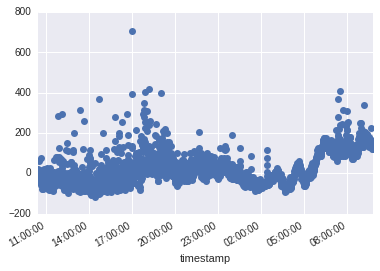

In [46]:

ds = xr.Dataset.from_dataframe(df.set_index('timestamp', 'id'))
ds_mean_1h = ds.resample(freq='1H', dim='timestamp', how='mean', skipna=True)
df.set_index('timestamp').co_correct_formula.plot(linestyle='none', marker='o')
#ds = ds.set_coords(['timestamp','id'])
#ds = ds.set_coords(['timestamp','id'])

In [47]:

#ds_mean_24h = ds.resample(freq='24H', dim='timestamp', how='mean', skipna=True)


         kings_co  co_correct_formula
count   19.000000           20.000000
mean   492.543860           24.000907
std    221.803333           59.295664
min    200.000000          -52.135116
25%    345.833333          -21.069975
50%    450.000000           17.351366
75%    537.500000           57.667147
max    950.000000          141.001313


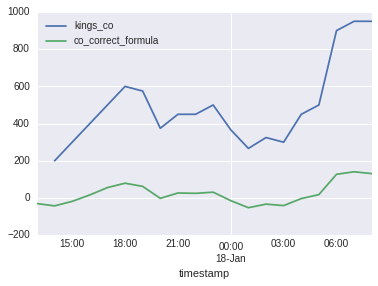

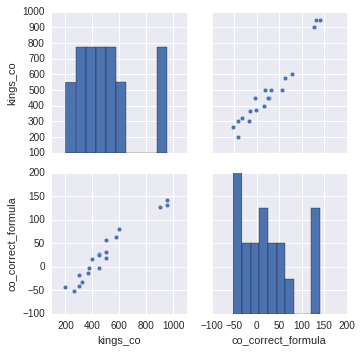

In [48]:
ds_merged = xr.merge([ds_kings_vol.rename(kings_prefix), ds_mean_1h]
                     , join='inner')
compare(ds_merged,'kings_co','co_correct_formula')

## Correct NO


In [49]:
ANALOG_REF_VOLTAGE = 3.3;

# sensor 1 values from mcu ( they are wrong and differ from datasheet)


mcu_NO2_WORKING_ELECTRODE_ZERO_OFFSET_MV  = 297;
mcu_NO2_AUXILIARY_ELECTRODE_ZERO_OFFSET_MV = 295;
mcu_NO2_SENSITIVITY = 0.228;


# reverse to raw readings
def reverse_NO2(NO2_working=None, NO2_aux=None, ppbNO2=None): 
       
#  float voltageNO2_working = ANALOG_REF_VOLTAGE * raw_NO2_working / 1024.0 * 1000.0;
#     //logMessage(VERBOSE, "Voltage NO2 Working Electrode (mV): " + String(voltageNO2_working));
#     sensor_readings->mvNO2_working = voltageNO2_working;
   
    raw_NO2_working_1 = NO2_working * 1024.0 / (1000.0 *ANALOG_REF_VOLTAGE)
    
#         float voltageNO2_working_corrected = voltageNO2_working - NO2_WORKING_ELECTRODE_ZERO_OFFSET_MV;
#     //logMessage(VERBOSE, "Corrected Voltage NO2 Working Electrode (mV): " + String(voltageNO2_working_corrected));
    
#     float ppbNO2 = voltageNO2_working_corrected / NO2_SENSITIVITY;
#     logMessage(INFO, "NO2:" + String(ppbNO2));
#     sensor_readings->ppbNO2 = ppbNO2;

    raw_NO2_working_2 = (ppbNO2 * mcu_NO2_SENSITIVITY + mcu_NO2_WORKING_ELECTRODE_ZERO_OFFSET_MV) * 1024.0 / (1000.0 * ANALOG_REF_VOLTAGE)
 
    assert abs(raw_NO2_working_1 - raw_NO2_working_2) < 0.05
    
#     float voltageNO2_aux = ANALOG_REF_VOLTAGE * raw_NO2_aux / 1024.0 * 1000.0;
#     //logMessage(VERBOSE, "Voltage NO2 Auxiliary Electrode (mV): " + String(voltageNO2_aux));
#     sensor_readings->mvNO2_aux = voltageNO2_aux;
      
    raw_NO2_aux = NO2_aux * 1024.0 / (1000.0 * ANALOG_REF_VOLTAGE)    
  
    return raw_NO2_working_1, raw_NO2_aux

   
# sensor #1 from datasheet( not from MCU)
NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  = 295;
NO2_WORKING_ELECTRODE_SENSOR_ZERO_MV  = 2;
NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV  = 295;
NO2_AUXILIARY_ELECTRODE_SENSOR_ZERO_MV  = 0;
NO2_SENSITIVITY = 0.197; # mv/ppb

def correct_no2(NO2_working=None, NO2_aux=None, ppbNO2=None, temp_correction = +1.09):
    # temp corretion is +1.09 up to 20 deg Cels, then 1.35, then 3 after 30C
    
    # reverse engineering CO conversion done on MCU     
    raw_NO2_working, raw_NO2_aux = reverse_NO2(NO2_working=NO2_working, NO2_aux=NO2_aux, ppbNO2=ppbNO2)
    
    scaled_aux =  raw_NO2_aux - NO2_AUXILIARY_ELECTRODE_SENSOR_ZERO_MV * temp_correction - NO2_AUXILIARY_ELECTRODE_ELECTRONIC_ZERO_MV
    
    scaled_working = raw_NO2_working - NO2_WORKING_ELECTRODE_ELECTRONIC_ZERO_MV  - NO2_WORKING_ELECTRODE_SENSOR_ZERO_MV

    return  (scaled_working -  scaled_aux )/NO2_SENSITIVITY

In [50]:
df['no2_correct_formula'] = df[['no2_working','no2_aux','no2']].apply(lambda x: correct_no2(x.values[0], x.values[1], x.values[2]), axis=1)
df.no2_correct_formula.describe()

count    2077.000000
mean       14.118406
std         8.133101
min       -10.152284
25%        10.167051
50%        15.207507
75%        20.247962
max        65.927088
Name: no2_correct_formula, dtype: float64

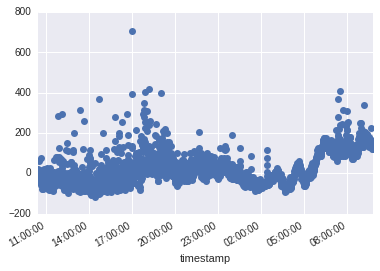

In [51]:

ds = xr.Dataset.from_dataframe(df.set_index('timestamp', 'id'))
ds_mean_1h = ds.resample(freq='1H', dim='timestamp', how='mean', skipna=True)
df.set_index('timestamp').co_correct_formula.plot(linestyle='none', marker='o')

In [52]:

ds_merged = xr.merge([ds_kings_vol.rename(kings_prefix), ds_mean_1h]
                     , join='inner')
`compare(ds_merged,'kings_no2','no2_correct_formula')

SyntaxError: invalid syntax (<ipython-input-52-5ac76d1d62ff>, line 4)

# Pm10

       kings_pm10        pm10
count   20.000000   20.000000
mean    58.368885   47.252279
std     11.370683   47.401765
min     43.119607   16.836222
25%     51.234482   22.076440
50%     55.703788   33.176817
75%     62.594729   38.825096
max     88.085102  215.159352


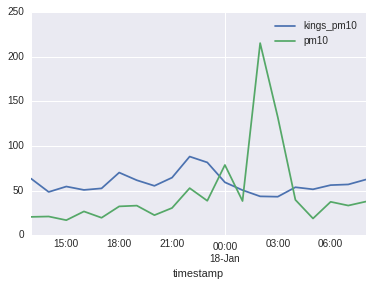

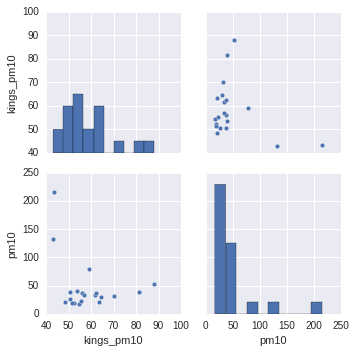

In [54]:
compare(ds_merged, 'kings_pm10', 'pm10')

In [55]:
df.pm10.astype(float)

2141     2.592
2140     9.347
2139    23.854
2138    18.573
2137    25.392
2136    20.582
2135    15.665
2134    14.902
2133    22.927
2132    30.895
2131    22.269
2130    18.512
2129    26.554
2128    14.948
2127    16.043
2126    20.352
2125    14.445
2124    21.692
2123    20.962
2122    17.845
2121    21.007
2120    13.883
2119    23.759
2118    10.650
2117    10.388
2116    14.339
2115    15.214
2114    12.079
2113    10.038
2112    15.257
         ...  
29      33.775
28      37.128
27      31.895
26      31.006
25      25.814
24      34.691
23      42.170
22      30.673
21      33.072
20      40.065
19      44.122
18      39.547
17      34.611
16      39.018
15      58.765
14      47.885
13      34.320
12      52.534
11      43.192
10      49.570
9       48.956
8       83.583
7       52.201
6       36.258
5       38.647
4       39.030
3       52.405
2       37.263
1       39.444
0       48.062
Name: pm10, dtype: float64

         kings_no2  no2_working
count  1061.000000   731.000000
mean     79.637440  3296.740147
std      38.258184     0.843191
min      11.495001  3279.452500
25%      49.307509  3296.800000
50%      75.339472  3296.800000
75%     105.464804  3296.800000
max     238.570508  3296.800000


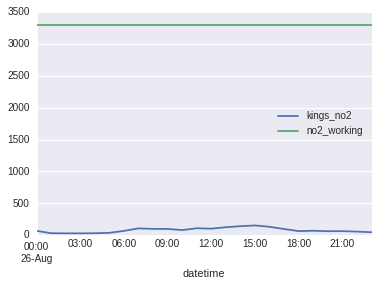

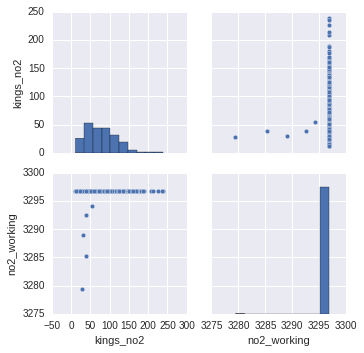

In [122]:
compare(ds_merged, 'kings_no2', 'no2_working')

## CO readings we don't get either


In [140]:
#if DEVICE_ID == 1
// Alphasense Gas Serial 12-000027
const int NO2_WORKING_ELECTRODE_ZERO_OFFSET_MV PROGMEM = 297;
const int NO2_AUXILIARY_ELECTRODE_ZERO_OFFSET_MV PROGMEM= 295;
const int CO_WORKING_ELECTRODE_ZERO_OFFSET_MV PROGMEM = 310;
const int CO_AUXILIARY_ELECTRODE_ZERO_OFFSET_MV PROGMEM = 272;
const float CO_SENSITIVITY PROGMEM= 0.197;
const float NO2_SENSITIVITY PROGMEM= 0.228;
const float OFFSET_VOLTAGE_20C_MV PROGMEM= 302.5;



SyntaxError: invalid syntax (<ipython-input-140-2cd736d0961b>, line 2)

In [ ]:

    //CO Sensor (in SN2 Slot and wired in to A0 & A1)
    int raw_CO_aux = analogRead(CO_AUX_PIN);
    //logMessage(VERBOSE, "A1 (CO Auxiliary Electrode): " + String(raw_CO_aux));
    
    float voltageCO_aux = ANALOG_REF_VOLTAGE * raw_CO_aux / 1024.0 * 1000.0;
    sensor_readings->mvCO_aux = voltageCO_aux;
    //logMessage(VERBOSE, "Voltage CO Auxiliary Electrode (mV): " + String(voltageCO_aux));
    
    float voltageCO_aux_corrected = voltageCO_aux - CO_AUXILIARY_ELECTRODE_ZERO_OFFSET_MV;
    //logMessage(VERBOSE, "Corrected Voltage CO Auxiliary Electrode (mV): " + String(voltageCO_aux_corrected));
    
    int raw_CO_working = analogRead(CO_WORKING_PIN);
    //logMessage(VERBOSE, "A0 (CO Working Electrode): " + String(raw_CO_working));
    
    float voltageCO_working = ANALOG_REF_VOLTAGE * raw_CO_working / 1024.0 * 1000.0;
    sensor_readings->mvCO_working = voltageCO_working;
    //logMessage(VERBOSE, "Voltage CO Working Electrode (mV): " + String(voltageCO_working));
    
    float voltageCO_working_corrected = voltageCO_working - CO_WORKING_ELECTRODE_ZERO_OFFSET_MV;
    //logMessage(VERBOSE, "Corrected Voltage CO Working Electrode (mV): " + String(voltageCO_working_corrected));
    
    float ppbCO = voltageCO_working_corrected / CO_SENSITIVITY;
    logMessage(INFO, "CO:" + String(ppbCO));
    sensor_readings->ppbCO = ppbCO;
    
    //NO2 Sensor (in SN1 Slot and wired in to A2 & A3)
    int raw_NO2_aux = analogRead(NO2_AUX_PIN);
    //logMessage(VERBOSE, "A3 (NO2 Auxiliary Electrode): " + String(raw_NO2_aux));
    
    float voltageNO2_aux = ANALOG_REF_VOLTAGE * raw_NO2_aux / 1024.0 * 1000.0;
    //logMessage(VERBOSE, "Voltage NO2 Auxiliary Electrode (mV): " + String(voltageNO2_aux));
    sensor_readings->mvNO2_aux = voltageNO2_aux;
    
    float voltageNO2_aux_corrected = voltageNO2_aux - NO2_AUXILIARY_ELECTRODE_ZERO_OFFSET_MV;
    //logMessage(VERBOSE, "Corrected Voltage NO2 Auxiliary Electrode (mV): " + String(voltageNO2_aux_corrected));
    
    int raw_NO2_working = analogRead(NO2_WORKING_PIN);
    //logMessage(VERBOSE, "A2 (NO2 Working Electrode): " + String(raw_NO2_working));
    
    float voltageNO2_working = ANALOG_REF_VOLTAGE * raw_NO2_working / 1024.0 * 1000.0;
    //logMessage(VERBOSE, "Voltage NO2 Working Electrode (mV): " + String(voltageNO2_working));
    sensor_readings->mvNO2_working = voltageNO2_working;
    
    float voltageNO2_working_corrected = voltageNO2_working - NO2_WORKING_ELECTRODE_ZERO_OFFSET_MV;
    //logMessage(VERBOSE, "Corrected Voltage NO2 Working Electrode (mV): " + String(voltageNO2_working_corrected));
    
    float ppbNO2 = voltageNO2_working_corrected / NO2_SENSITIVITY;
    logMessage(INFO, "NO2:" + String(ppbNO2));
    sensor_readings->ppbNO2 = ppbNO2;
    

In [2]:
a = reverse_co(ppbCO = 670.768, CO_aux = 350.734, CO_working = 442.138)


In [71]:
# making sure that PM10 is the same
ds_kings_merged = xr.merge([ds_kings_mass[['pm10', 'pm10_raw']].rename({'pm10': 'kings_mass_pm10', 'pm10_raw': 'kings_mass_pm10_raw'}), 
                            ds_kings_vol[['pm10', 'pm10_raw']].rename({'pm10': 'kings_vol_pm10', 'pm10_raw': 'kings_vol_pm10_raw'})
                           ], join='inner')


NameError: name 'ds_kings_mass' is not defined

In [3]:
readings = [ reverse_co(ppbCO = 670.768, CO_aux = 350.734, CO_working = 442.138),
reverse_co(ppbCO = 755.324, CO_aux = 349.612, CO_working = 458.793),
reverse_co(ppbCO = 882.585, CO_aux = 349.344, CO_working = 483.866)]

In [4]:
a = zip(readings,(200,300,400))

In [16]:

# from https://github.com/analogdevicesinc/mbed-adi/blob/a4fd58b2434f2ac84cd4ff631a0bca10ec0a692f/libraries/CN0357/CN0357.cpp
# gas sensor sensitivity in mV/ppb - 0.197 mV/ppb


CO_SENSITIVITY_mV_PPB = CO_SENSITIVITY #* pow(10, -3));

#(fabs(adcVoltage) / _RDACvalue) / _sensor_sensitivity;


In [199]:
a


[((137.1967612121212, 137.1977839709091, 108.83382303030302), 200),
 ((142.3648581818182, 142.36666662787877, 108.48566303030304), 300),
 ((150.14508606060605, 150.1460929939394, 108.40250181818182), 400)]

In [17]:
CO_SENSITIVITY_mV_PPB

0.197

In [20]:
for x in a:
    #print (x[0][0] /  (x[0][2] )  )/CO_SENSITIVITY_mV_PPB 
    
    print (x[0][0] -  (x[0][2] )  )/CO_SENSITIVITY_mV_PPB, x[1] 
    
    #print (x[0][0] -  (x[0][2] )  )*CO_SENSITIVITY_mV_PPB 
    
    #print (x[0][0]   )/CO_SENSITIVITY_mV_PPB 
    #print (x[0][2]   )/CO_SENSITIVITY_mV_PPB 
    

143.974305491 200
171.975609906 300
211.891290571 400


In [156]:
df_1h.head().T


,4,5,6
timestamp,2017-01-17 14:00:00,2017-01-17 15:00:00,2017-01-17 16:00:00
co,670.768,755.324,882.585
pm1,7.84788,1.38602,8.10473
w_pm10,0,0,0
co_aux,350.734,349.612,349.344
sampling_period,39.7574,39.8639,40.551
co_working,442.138,458.793,483.866
w_pm1,0,0,0
sample_flow_rate,0.692868,0.691156,0.671393
gas_temp,260.667,260.729,260.355


         kings_co            co
count  921.000000  7.310000e+02
mean     0.540233  1.202733e+04
std      0.342642  1.700510e-12
min     -0.193333  1.202733e+04
25%      0.241280  1.202733e+04
50%      0.581856  1.202733e+04
75%      0.765600  1.202733e+04
max      1.653696  1.202733e+04


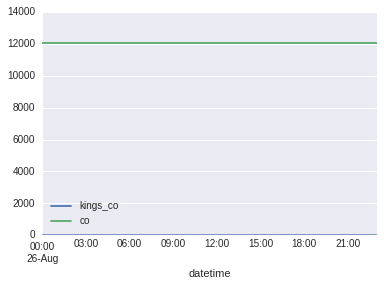

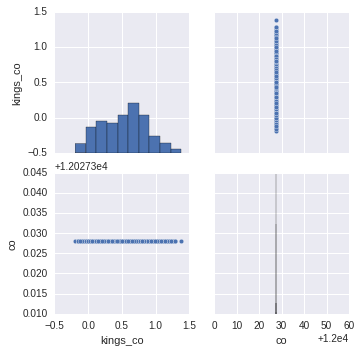

In [121]:
compare(ds_merged, 'kings_co', 'co')

# Wind speed and flow rate don't seem to be related. check time alignment lag


          kings_ws  sample_flow_rate
count  1069.000000        731.000000
mean      1.270370          4.029253
std       1.104762          0.657688
min       0.150000          2.521000
25%       0.237500          3.584902
50%       0.962500          3.880295
75%       2.037500          4.244710
max       5.512500          6.167000


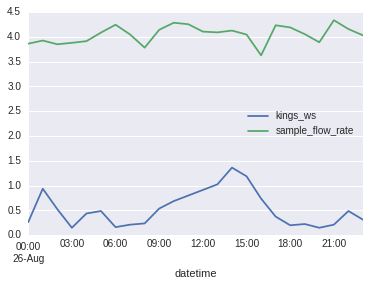

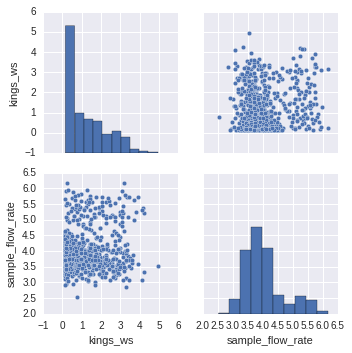

In [118]:
compare(ds_merged, 'kings_ws', 'sample_flow_rate')

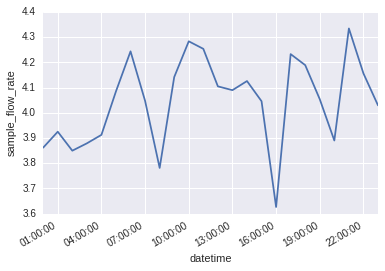

In [119]:
ds_merged.sel(datetime='2016-08-26').sample_flow_rate.plot()

# It looks like the sensor has been moved arounda

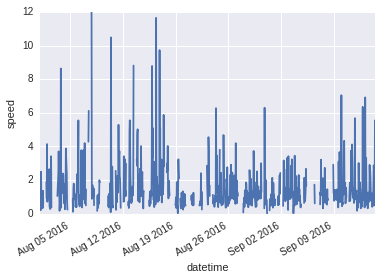

In [86]:

ds_merged.speed.plot()

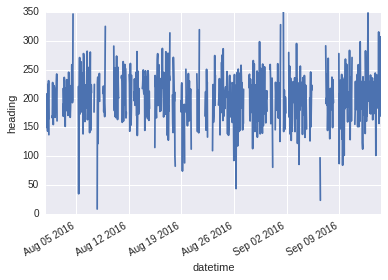

In [85]:
ds_merged.heading.plot()

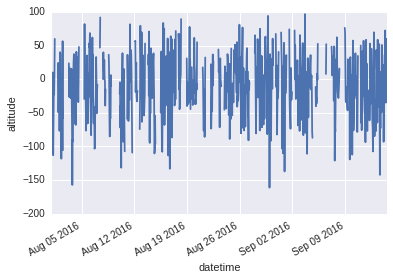

In [87]:
ds_merged.altitude.plot()

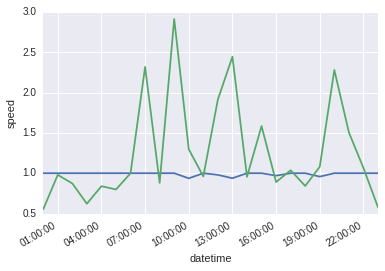

In [95]:
ds_merged.sel(datetime='2016-08-26').gps_fix.plot()
ds_merged.sel(datetime='2016-08-26').speed.plot()

In [75]:
ds_kings_merged.to_dataframe().head()

,kings_mass_pm10,kings_mass_pm10_raw,kings_vol_pm10,kings_vol_pm10_raw
datetime,,,,
2016-08-01 01:00:00,10.539265,13.745550,10.539265,13.745550
2016-08-01 02:00:00,12.006873,11.258260,12.006873,11.258260
2016-08-01 03:00:00,10.511431,12.010993,10.511431,12.010993
2016-08-01 04:00:00,18.532217,23.694710,18.532217,23.694710
2016-08-01 05:00:00,21.258345,27.982012,21.258345,27.982012


In [24]:
ds_merged

<xarray.Dataset>
Dimensions:             (datetime: 1069)
Coordinates:
  * datetime            (datetime) datetime64[ns] 2016-08-01T01:00:00 ...
Data variables:
    kings_vol_pm10      (datetime) float64 10.54 12.01 10.51 18.53 21.26 ...
    kings_vol_pm10_raw  (datetime) float64 13.75 11.26 12.01 23.69 27.98 ...
    pm2_5               (datetime) float64 1.68 2.309 2.182 2.729 3.056 ...
    co                  (datetime) float64 1.203e+04 1.203e+04 1.203e+04 ...
    pm1                 (datetime) float64 0.6025 0.6121 0.7121 0.9235 1.012 ...
    co_aux              (datetime) float64 3.297e+03 3.297e+03 3.297e+03 ...
    sampling_period     (datetime) float64 3.962 4.29 5.094 4.873 5.094 ...
    no2_working         (datetime) float64 3.297e+03 3.297e+03 3.297e+03 ...
    gas_temp            (datetime) float64 75.13 94.57 79.38 70.05 69.99 ...
    date                (datetime) float64 2.016e+13 2.016e+13 2.016e+13 ...
    speed               (datetime) float64 0.9811 0.2084 2.497 0.65

In [320]:
ds_merged.sel(datetime='2016-08-22')[['kings_vol_pm10', 'pm10']].to_dataframe().dropna().head(30)

,kings_vol_pm10,pm10
datetime,,
2016-08-22 04:00:00,16.209104,18.935000
2016-08-22 05:00:00,25.916478,17.873150
2016-08-22 06:00:00,27.686242,20.016500
2016-08-22 07:00:00,28.826600,20.968513
2016-08-22 08:00:00,30.666405,24.964171
2016-08-22 09:00:00,30.406255,22.400870
2016-08-22 10:00:00,31.388690,22.623955
2016-08-22 11:00:00,30.051786,20.074684
2016-08-22 12:00:00,33.778673,3.339833


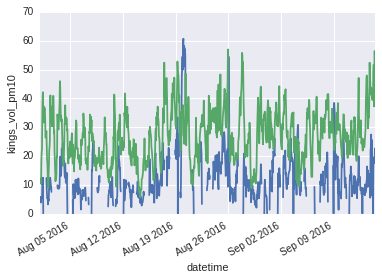

In [330]:
ds_merged['pm10'].plot.line()
ds_merged['kings_vol_pm10'].plot.line()

       kings_vol_pm10        pm10       error
count     1067.000000  731.000000  729.000000
mean        27.121945   12.774742  -14.243967
std          9.022637    8.727939   10.338175
min          5.684405    0.000000  -50.269870
25%         20.098618    7.377160  -20.217195
50%         26.784397   10.644952  -14.530732
75%         33.101279   16.550782   -8.355470
max         56.997479   60.726886   33.709723


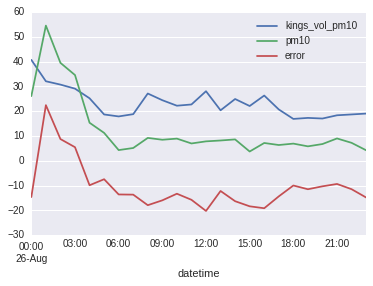

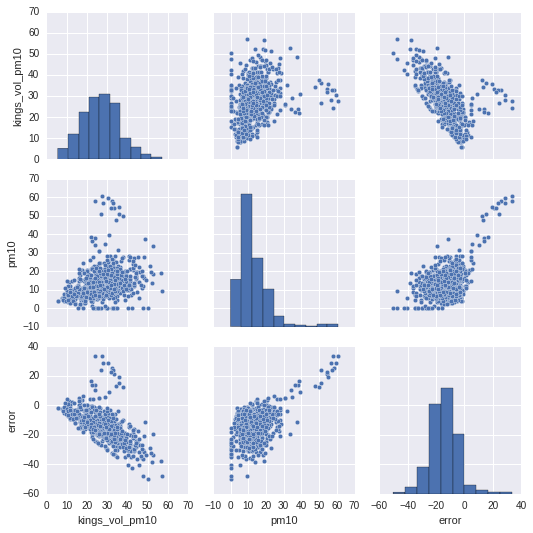

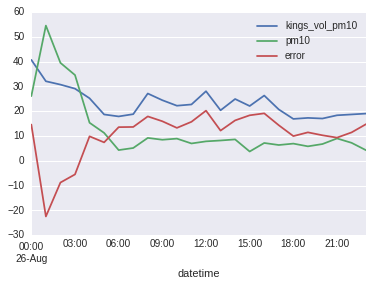

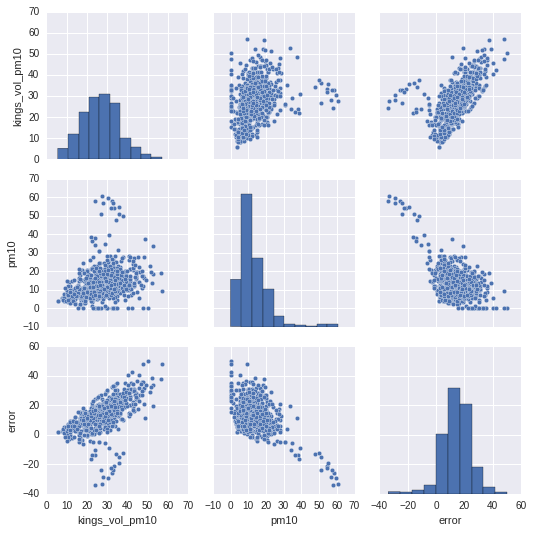

In [19]:
compare(ds_merged) 'kings_vol_pm10','pm10']]
ds_merged_pm10['error'] = ds_merged['kings_vol_pm10'] - ds_merged['pm10']
ds_merged_pm10.sel(datetime='2016-08-26').to_dataframe().plot()
sns.pairplot(ds_merged_pm10.to_dataframe().dropna().reset_index(), vars=ds_merged_pm10.data_vars)

In [342]:
ds_merged_pm10.to_dataframe().describe()

,kings_vol_pm10,pm10
count,1067.000000,731.000000
mean,27.121945,12.774742
std,9.022637,8.727939
min,5.684405,0.000000
25%,20.098618,7.377160
50%,26.784397,10.644952
75%,33.101279,16.550782
max,56.997479,60.726886


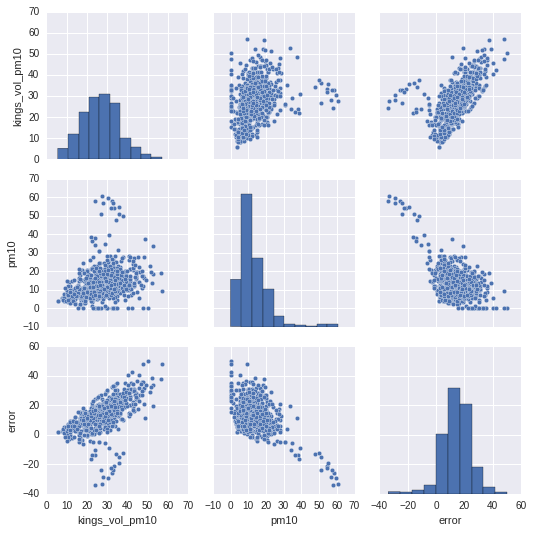

In [16]:
# The error grows linearly with the kings_vol_pm10 measurement.
# So can add a constant + multiplicative factor to make them match. linear regression basically


sns.pairplot(ds_merged_pm10.to_dataframe().dropna().reset_index(), vars=ds_merged_pm10.data_vars)

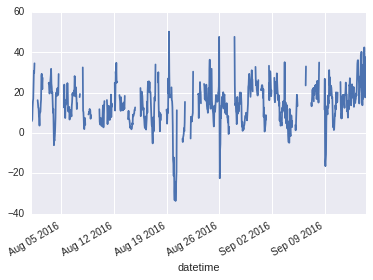

In [335]:
(ds_merged['kings_vol_pm10'] - ds_merged['pm10']).plot.line()

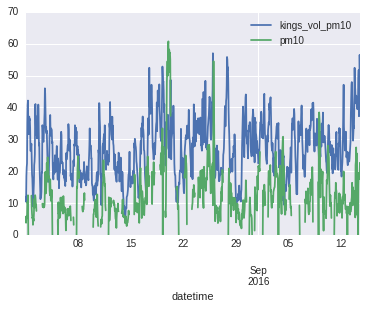

In [332]:
ds_merged[['kings_vol_pm10','pm10']].to_dataframe().plot()

In [331]:
ds_merged[['kings_vol_pm10', 'pm10']].to_dataframe().dropna().head(20)

,kings_vol_pm10,pm10
datetime,,
2016-08-01 01:00:00,10.539265,4.752500
2016-08-01 02:00:00,12.006873,5.754053
2016-08-01 03:00:00,10.511431,3.835120
2016-08-01 04:00:00,18.532217,5.812543
2016-08-01 05:00:00,21.258345,5.555510
2016-08-01 06:00:00,22.452533,5.493571
2016-08-01 07:00:00,35.335467,10.306574
2016-08-01 08:00:00,40.721658,9.969271
2016-08-01 09:00:00,42.158228,12.465130


In [277]:
ds_kings_mass_renamed = ds_kings_mass['pm10', 'pm10_raw'].rename({'pm10': 'kings_mass_pm10', 'pm10_raw': 'kings_mass_pm10_raw'})
ds_merged = xr.merge([ds_kings_mass_renamed, ds_merged], join='inner')


KeyError: ('pm10', 'pm10_raw')

In [236]:
ds.datetime.values

array(['2016-02-06T20:04:00.709000000+0000',
       '2016-04-21T11:38:33.078000000+0100',
       '2016-04-21T11:50:47.242000000+0100', ...,
       '2016-09-14T14:54:23.446000000+0100',
       '2016-09-14T14:55:42.584000000+0100',
       '2016-09-14T14:58:15.418000000+0100'], dtype='datetime64[ns]')

In [237]:
df.datetime.hist()

AttributeError: 'DataFrame' object has no attribute 'datetime'

In [211]:
ds_mean

<xarray.Dataset>
Dimensions:           (datetime: 5298)
Coordinates:
  * datetime          (datetime) datetime64[ns] 2016-02-06T20:00:00 ...
Data variables:
    pm2_5             (datetime) float64 3.619 nan nan nan nan nan nan nan ...
    co                (datetime) float64 1.19e+03 nan nan nan nan nan nan ...
    pm1               (datetime) float64 1.045 nan nan nan nan nan nan nan ...
    co_aux            (datetime) float64 219.1 nan nan nan nan nan nan nan ...
    sampling_period   (datetime) float64 5.094 nan nan nan nan nan nan nan ...
    no2_working       (datetime) float64 212.7 nan nan nan nan nan nan nan ...
    gas_temp          (datetime) float64 29.4 nan nan nan nan nan nan nan ...
    date              (datetime) float64 2.016e+13 nan nan nan nan nan nan ...
    speed             (datetime) float64 9.0 nan nan nan nan nan nan nan nan ...
    no2               (datetime) float64 -38.09 nan nan nan nan nan nan nan ...
    no2_aux           (datetime) float64 283.6 nan n

In [240]:
ds_mean.values()[0].datetime

<xarray.DataArray 'datetime' (datetime: 5298)>
array(['2016-02-06T20:00:00.000000000+0000',
       '2016-02-06T21:00:00.000000000+0000',
       '2016-02-06T22:00:00.000000000+0000', ...,
       '2016-09-14T12:00:00.000000000+0100',
       '2016-09-14T13:00:00.000000000+0100',
       '2016-09-14T14:00:00.000000000+0100'], dtype='datetime64[ns]')
Coordinates:
  * datetime  (datetime) datetime64[ns] 2016-02-06T20:00:00 ...

In [224]:
ds_mean.values[0]

TypeError: 'instancemethod' object has no attribute '__getitem__'

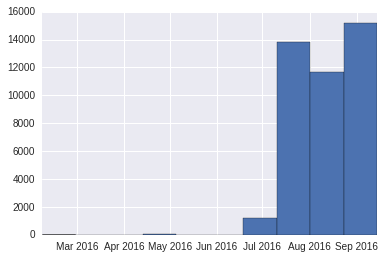

In [249]:
pd.to_datetime(df.timestamp).hist()

In [242]:
ds_mean.sel(datetime='2016-01-31T15:00:00+0000')

KeyError: '2016-01-31T15:00:00+0000'

In [130]:
ds['latitude' > -0.155, 'latitude' <  -0.154, 'longitude' > 51.5,  'longitude' < 51.6]

KeyError: (True, False, True, False)

In [151]:

ds

<xarray.Dataset>
Dimensions:           (datetime: 41926, index: 41926)
Coordinates:
  * index             (index) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
    longitude         (index) float64 -0.1544 -0.1547 -0.1547 -0.1547 ...
    latitude          (index) float64 51.52 51.52 51.52 51.52 51.52 51.52 ...
  * datetime          (datetime) datetime64[ns] 2016-09-14T13:58:15.418000 ...
Data variables:
    co_working        (index) object '3296.8' '3296.8' '3296.8' '3296.8' ...
    co_aux            (index) float64 3.297e+03 3.297e+03 3.297e+03 ...
    no2_working       (index) float64 3.297e+03 3.297e+03 3.297e+03 ...
    no2_aux           (index) float64 3.297e+03 3.297e+03 3.297e+03 ...
    gas_temp          (index) float64 90.7 90.7 87.4 87.4 87.4 87.4 90.7 ...
    sample_flow_rate  (index) float64 4.625 4.625 3.7 4.353 4.353 4.353 ...
    lonet_bat         (index) int64 10 13 14 14 14 15 16 16 16 17 17 18 18 ...
    heading           (index) float64 24.4 16.9 312.8 256.5 333

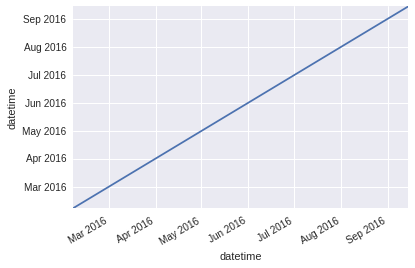

In [153]:
ds.datetime.plot()

In [142]:
df[(df.longitude > -0.155) & (df.longitude <  -0.154) & (df.latitude > 51.5) &  (df.latitude < 51.6 )]

37562

In [135]:
ds.loc[:,51.5 : 51.6]

TypeError: can only lookup dictionaries from Dataset.loc

In [27]:
df.head().T

,0,1,2,3,4
co_working,3296.8,3296.8,3296.8,3296.8,3296.8
co_aux,3296.8,3296.8,3296.8,3296.8,3296.8
no2_working,3296.8,3296.8,3296.8,3296.8,3296.8
no2_aux,3296.8,3296.8,3296.8,3296.8,3296.8
gas_temp,90.7,90.7,87.4,87.4,87.4
sample_flow_rate,4.625,4.625,3.7,4.353,4.353
lonet_bat,10,13,14,14,14
heading,24.4,16.9,312.8,256.5,333.9
speed,2.52,1.19,1.11,1.43,0.11
altitude,68.5,21.5,35.6,92.3,84.9


In [28]:
ds.pm10.plot()

ValueError: need more than 1 value to unpack

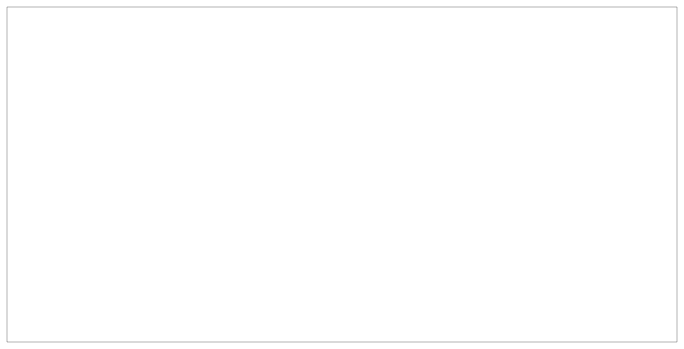

In [76]:
plt.figure(figsize=(14,6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()
ds.co.plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), x='latitude', y='longitude', add_colorbar=False)
ax.coastlines()
ax.set_ylim([0,90]);

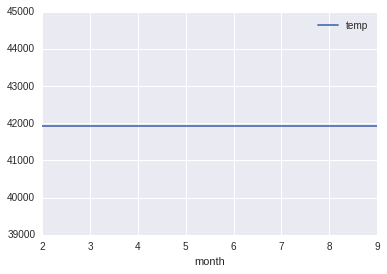

In [57]:
ds.groupby('datetime.month').count().temp.to_dataframe().plot()

In [84]:
l = ds['latitude']

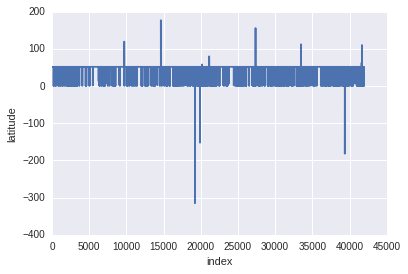

In [85]:
l.plot()

In [86]:
df.latitude.describe()


count    41926.000000
mean        50.940958
std          6.001477
min       -315.000000
25%         51.521999
50%         51.522419
75%         51.522747
max        176.739990
Name: latitude, dtype: float64

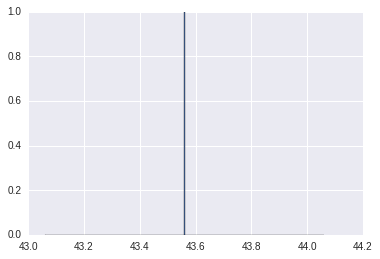

In [80]:
ds[(ds['latitude'] > 43.5) & (ds.latitude < 43.6) ].latitude.hist(bins=1000)


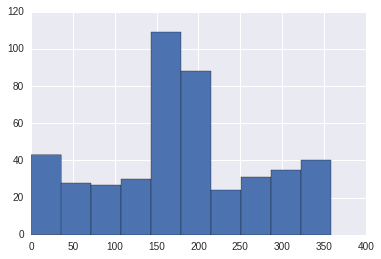

In [74]:
df[df.longitude > 0].longitude.hist()

In [77]:
ds.isel['']

<xarray.Dataset>
Dimensions:           (datetime: 41926, index: 41926)
Coordinates:
  * index             (index) int64 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 ...
    longitude         (index) float64 -0.1544 -0.1547 -0.1547 -0.1547 ...
    latitude          (index) float64 51.52 51.52 51.52 51.52 51.52 51.52 ...
  * datetime          (datetime) datetime64[ns] 2016-09-14T13:58:15.418000 ...
Data variables:
    co_working        (index) object '3296.8' '3296.8' '3296.8' '3296.8' ...
    co_aux            (index) float64 3.297e+03 3.297e+03 3.297e+03 ...
    no2_working       (index) float64 3.297e+03 3.297e+03 3.297e+03 ...
    no2_aux           (index) float64 3.297e+03 3.297e+03 3.297e+03 ...
    gas_temp          (index) float64 90.7 90.7 87.4 87.4 87.4 87.4 90.7 ...
    sample_flow_rate  (index) float64 4.625 4.625 3.7 4.353 4.353 4.353 ...
    lonet_bat         (index) int64 10 13 14 14 14 15 16 16 16 17 17 18 18 ...
    heading           (index) float64 24.4 16.9 312.8 256.5 333

In [81]:
df.latitude

0        51.522873
1        51.522434
2        51.522724
3        51.522869
4        51.522846
5        51.522907
6        51.522884
7        51.523056
8        51.522881
9        51.522881
10       51.522903
11       51.522812
12       51.522720
13       51.522377
14       51.522533
15       51.522907
16       51.522728
17       51.522797
18       51.522881
19       51.522842
20       51.523041
21       51.522793
22       51.522964
23       51.522968
24       51.522873
25       51.522835
26       51.522835
27       51.522793
28       51.522362
29       51.522427
           ...    
41896     0.000000
41897     0.000000
41898     0.000000
41899     0.000000
41900     0.000000
41901     0.000000
41902    51.538410
41903    51.538662
41904    51.538456
41905    51.538635
41906    51.538597
41907    51.538773
41908    51.538788
41909    51.539436
41910    51.538456
41911    51.538486
41912    51.538334
41913    51.537922
41914    51.537678
41915     0.000000
41916     0.000000
41917     0.

## Does GSM function correctly?
Expected an update every N seconds

In [23]:
ds

<xarray.Dataset>
Dimensions:               (index: 2142)
Coordinates:
  * index                 (index) int64 2141 2140 2139 2138 2137 2136 2135 ...
    timestamp             (index) datetime64[ns] 2017-01-17T10:26:36.710895 ...
    id                    (index) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Data variables:
    altitude              (index) float64 0.0 0.0 75.0 81.3 81.0 79.1 78.6 ...
    co                    (index) float64 978.3 733.0 1.093e+03 733.0 749.3 ...
    co_aux                (index) float64 364.2 348.0 357.7 344.8 348.0 ...
    co_working            (index) float64 502.7 454.4 525.3 454.4 457.6 ...
    gas_temp              (index) float64 32.7 258.2 255.0 255.0 258.2 258.2 ...
    gps_fix               (index) float64 0.0 0.0 1.0 1.0 1.0 1.0 1.0 1.0 ...
    heading               (index) float64 3.0 3.0 152.1 249.4 285.7 283.8 ...
    humidity              (index) float64 50.0 51.1 50.4 50.7 50.7 50.8 50.2 ...
    latitude              (index) float64 0.89

In [27]:
df.timestamp.min()

Timestamp('2017-01-17 10:26:36.710895')

## Only 35% of readings received in the time period. Out of them 90% are within about a minute from each other.

In [32]:


start = df.timestamp.min()
#end = '2016-08-10 00:00:00'
end = df.timestamp.max()

time_period = slice(start,end)
print 'Expected', len(pd.date_range(start=start, end=end,freq='40s'))
ds_one_day = ds.loc[dict(date=time_period)]
print 'Actual', ds_one_day.dims



Expected 2103


KeyError: Timestamp('2017-01-17 10:26:36.710895')

In [181]:
21.0/23.0

0.9130434782608695

23

In [167]:
ds_one_day.dims

Frozen(SortedKeysDict(OrderedDict([('datetime', 1471)])))

In [134]:
#ds_short = ds.loc[dict(datetime=slice('2016-08-01','2016-09-22'))]


In [173]:
ds_one_day.to_dataframe().head()

,co_working,co_aux,no2_working,no2_aux,gas_temp,sample_flow_rate,lonet_bat,heading,speed,altitude,...,temp,sampling_period,pm10,pm2_5,pm1,no2,longitude,latitude,co,timestamp
datetime,,,,,,,,,,,,,,,,,,,,,
2016-08-07 00:00:51.593,3296.8,3296.8,3296.8,3296.8,77.8,4.353,35,297.5,0.00,44.0,...,22.0,5.094,11.023,9.836,3.748,14109.07,-0.154552,51.522991,12027.328,2016-08-07 00:00:51.593
2016-08-07 00:02:03.710,3296.8,3296.8,3296.8,3296.8,77.8,6.727,35,4.3,1.69,92.2,...,21.9,5.094,7.589,6.270,2.389,14109.07,-0.154573,51.522888,12027.328,2016-08-07 00:02:03.710
2016-08-07 00:03:17.823,3296.8,3296.8,3296.8,3296.8,77.8,5.286,35,182.9,0.00,29.3,...,21.9,5.094,12.406,6.639,2.596,14109.07,-0.154715,51.522480,12027.328,2016-08-07 00:03:17.823
2016-08-07 00:04:34.084,3296.8,3296.8,3296.8,3296.8,77.8,5.286,35,1.6,0.02,76.0,...,21.8,5.094,7.926,7.294,3.113,14109.07,-0.154465,51.522907,12027.328,2016-08-07 00:04:34.084
2016-08-07 00:05:41.503,3296.8,3296.8,3296.8,3296.8,84.2,5.286,35,1.6,0.85,83.4,...,21.9,0.000,0.000,0.000,0.000,14109.07,-0.154470,51.522984,12027.328,2016-08-07 00:05:41.503


In [174]:
ds_short = ds_short.to_dataframe()

AttributeError: 'DataFrame' object has no attribute 'to_dataframe'

Add a column that 

In [175]:
#ds_short['delta'] = (ds_short['timestamp'] - ds_short['timestamp'].shift(datetime=1)).fillna(0)

def add_delta(df):
    df['delta'] = (df['timestamp'] - df['timestamp'].shift(1)).fillna(0).astype('timedelta64[s]')
    df['good_delta'] = (df['delta'] > 40) & (df['delta'] < 80)
    return df

In [176]:
df_one_day = add_delta(ds_one_day.to_dataframe())

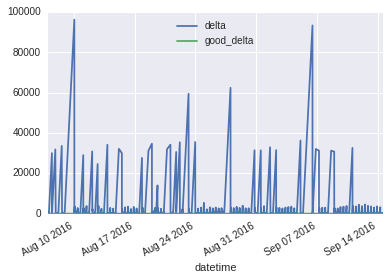

In [177]:
df_one_day[['delta', 'good_delta']].plot()

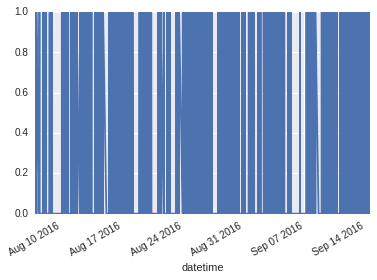

In [178]:
df_one_day.good_delta.plot()

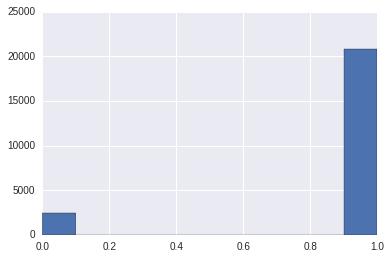

In [179]:
df_one_day.good_delta.hist()

In [180]:
df_one_day.good_delta.describe()

count     23248
unique        2
top        True
freq      20805
Name: good_delta, dtype: object

In [120]:
ds_short.head()

,co_working,co_aux,no2_working,no2_aux,gas_temp,sample_flow_rate,lonet_bat,heading,speed,altitude,...,pm10,pm2_5,pm1,no2,longitude,latitude,co,timestamp,delta,good_delta
datetime,,,,,,,,,,,,,,,,,,,,,
2016-08-01 00:00:52.260,3296.8,3296.8,3296.8,3296.8,77.8,4.625,33,227.9,0.0,-57.3,...,0.000,0.000,0.000,14109.07,-0.155122,51.521755,12027.328,2016-08-01 00:00:52.260,0.0,False
2016-08-01 00:02:02.992,3296.8,3296.8,3296.8,3296.8,74.6,4.353,33,9.0,10.0,0.0,...,2.434,2.214,0.863,14109.07,131.200000,2.020000,12027.328,2016-08-01 00:02:02.992,70.0,True
2016-08-01 00:03:15.117,3296.8,3296.8,3296.8,3296.8,74.6,3.700,33,31.1,0.0,14.5,...,2.817,2.619,0.993,14109.07,-0.154430,51.522724,12027.328,2016-08-01 00:03:15.117,72.0,True
2016-08-01 00:04:27.672,3296.8,3296.8,3296.8,3296.8,74.6,3.700,33,197.0,0.0,11.0,...,17.658,2.889,0.938,14109.07,-0.154483,51.522621,12027.328,2016-08-01 00:04:27.672,72.0,True
2016-08-01 00:05:38.743,3296.8,3296.8,3296.8,3296.8,74.6,8.222,32,197.0,0.0,10.7,...,6.439,1.294,0.504,14109.07,-0.154472,51.522636,12027.328,2016-08-01 00:05:38.743,71.0,True


In [106]:
ds_short.delta.describe()

count    27302.000000
mean       140.585085
std       1472.379564
min          0.000000
25%         71.000000
50%         73.000000
75%         75.000000
max      96226.000000
Name: delta, dtype: float64

(0, 100)

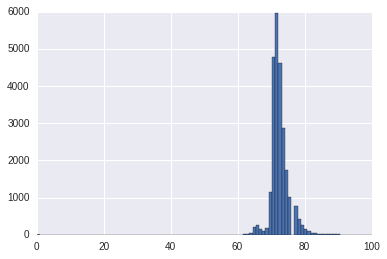

In [116]:
ax_list = ds_short.delta.hist(bins=100000)
ax_list.set_xlim((0,100))

In [104]:
ds_short.delta.describe()

count    27302.000000
mean       140.585085
std       1472.379564
min          0.000000
25%         71.000000
50%         73.000000
75%         75.000000
max      96226.000000
Name: delta, dtype: float64

In [86]:
data_points_per_day =  ds_short.groupby('datetime.date').count().timestamp.to_dataframe()

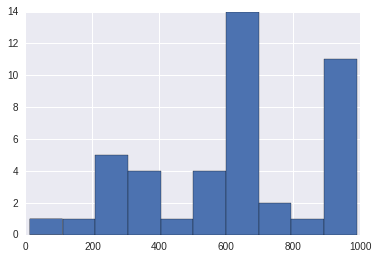

In [56]:
data_points_per_day.timestamp.hist()

In [118]:
ds_short.T

datetime,2016-08-01 00:00:52.260000,2016-08-01 00:02:02.992000,2016-08-01 00:03:15.117000,2016-08-01 00:04:27.672000,2016-08-01 00:05:38.743000,2016-08-01 00:06:51.827000,2016-08-01 00:08:09.234000,2016-08-01 00:09:20.078000,2016-08-01 00:10:25.430000,2016-08-01 00:11:37.017000,...,2016-09-14 13:45:53.505000,2016-09-14 13:47:05.150000,2016-09-14 13:48:17.819000,2016-09-14 13:49:30.761000,2016-09-14 13:50:43.402000,2016-09-14 13:51:55.368000,2016-09-14 13:53:06.840000,2016-09-14 13:54:23.446000,2016-09-14 13:55:42.584000,2016-09-14 13:58:15.418000
co_working,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,...,3296.8,3296.8data.sparkfun.com,3296.8data.sparkfun.com,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8
co_aux,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,...,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8
no2_working,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,...,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8
no2_aux,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,...,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8,3296.8
gas_temp,77.8,74.6,74.6,74.6,74.6,74.6,74.6,74.6,77.8,74.6,...,90.7,90.7,90.7,90.7,87.4,87.4,87.4,87.4,90.7,90.7
sample_flow_rate,4.625,4.353,3.7,3.7,8.222,3.524,3.7,3.7,3.7,6.727,...,4.353,3.7,4.625,4.625,4.353,4.353,4.353,3.7,4.625,4.625
lonet_bat,33,33,33,33,32,32,32,32,32,32,...,17,16,16,16,15,14,14,14,13,10
heading,227.9,9,31.1,197,197,38,14.6,97.6,332,5.6,...,21.4,12.7,356.2,347.4,201.8,333.9,256.5,312.8,16.9,24.4
speed,0,10,0,0,0,1.19,0.06,0.33,0.3,1.85,...,8.82,11.78,7.74,3.85,0,0.11,1.43,1.11,1.19,2.52
altitude,-57.3,0,14.5,11,10.7,22.8,15.6,42.2,43.1,39.7,...,143.9,128.1,145.8,128.8,70.9,84.9,92.3,35.6,21.5,68.5


In [57]:
data_points_per_day = data_points_per_day[ (data_points_per_day.date > pd.to_datetime('2016-08-01'))
                                          & (data_points_per_day.date < pd.to_datetime('2016-09-22')) ]

AttributeError: 'DataFrame' object has no attribute 'date'

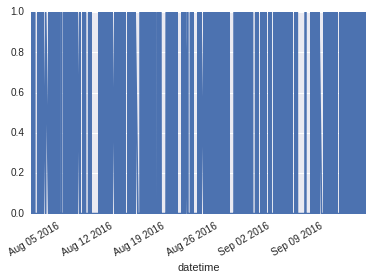

In [123]:
ds_short.good_delta.plot()

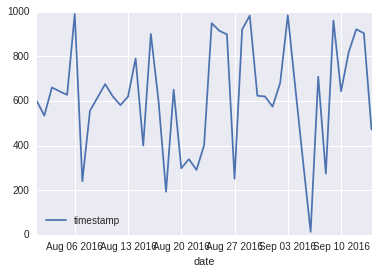

In [58]:
data_points_per_day.plot()

UnboundLocalError: local variable 'x' referenced before assignment

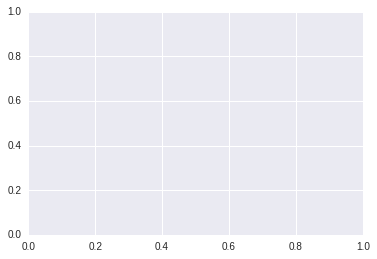

In [22]:
sns.tsplot(data_points_per_day.to_dataframe())